In [134]:

# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle

def get_text_from_url(url):
    r = requests.get(url).text
    soup = BeautifulSoup(r, "lxml")
    text = soup.get_text()
    return text


nominees = ['Trump', 'Clinton']
urls = ['https://raw.githubusercontent.com/Gandhi24/Presidential-Debate-Analysis/master/Trump.txt', 
       'https://raw.githubusercontent.com/Gandhi24/Presidential-Debate-Analysis/master/Clinton.txt']


In [135]:
transcripts = [get_text_from_url(url) for url in urls]

In [136]:
!mkdir transcripts
for i, c in enumerate(nominees):
     with open("transcripts/" + c + ".txt", "wb") as file:
         pickle.dump(transcripts[i], file)

In [137]:
data = {}
for i, c in enumerate(nominees):
    with open("transcripts/" + c + ".txt", "rb") as file:
        data[c] = pickle.load(file)

In [138]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ''.join(list_of_text)
    return combined_text

In [139]:
data_combined = {key: [combine_text(value)] for (key, value) in data.items()}
#data_combined['Clinton']

In [140]:
import pandas as pd
pd.set_option('max_colwidth',150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['transcript']
data_df = data_df.sort_index()
data_df

,transcript
Clinton,"Well, thank you. Are you a teacher? Yes, I think that that’s a very good question, because I’ve heard from lots of teachers and parents about some..."
Trump,"Well, I actually agree with that. I agree with everything she said. I began this campaign because I was so tired of seeing such foolish things hap..."


In [190]:
#regular expressions
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\t', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [191]:
data_clean = pd.DataFrame(data_df.transcript.apply(round1))
data_clean


,transcript
Clinton,well thank you are you a teacher yes i think that thats a very good question because ive heard from lots of teachers and parents about some of the...
Trump,well i actually agree with that i agree with everything she said i began this campaign because i was so tired of seeing such foolish things happen...


In [192]:
full_names = ['Hillary Clinton', 'Donald Trump']

In [145]:
data_df['full_name'] = full_names

In [193]:
data_df.to_pickle("corpus.pkl")

In [194]:
# create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(data_clean.transcript)
data_cv
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,abe,able,aboutok,abraham,absolute,absolutely,abusive,accountableno,accounts,accurate,...,youd,youjustice,young,youre,yourselfbecause,youve,youwell,zero,zone,zones
Clinton,0,8,1,1,0,2,0,1,1,1,...,0,0,2,7,0,3,0,4,1,1
Trump,2,5,0,2,1,5,2,0,0,0,...,2,1,1,5,1,4,1,0,0,1


In [148]:
data_dtm.to_pickle("dtm.pkl")

In [149]:
data_clean.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

In [179]:
import pandas as pd

data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data

,Clinton,Trump
abe,0,2
able,8,5
aboutok,1,0
abraham,1,2
absolute,0,1
absolutely,2,5
abusive,0,2
accountableno,1,0
accounts,1,0
accurate,1,0


In [182]:
# Find the top 30 words said by the nominees
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

#top_dict

In [183]:
# Print the top 15 words said by each nominee
for nominee, top_words in top_dict.items():
    print(nominee)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('=====')

Clinton
people, want, think, donald, lot, thats, know, said, president, just, country, going, insurance, ive
=====
Trump
going, people, know, look, country, shes, like, im, say, said, think, dont, just, great
=====


In [184]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for both the nominees
words = []
for nominee in data.columns:
    top = [word for (word, count) in top_dict[nominee]]
    for t in top:
        words.append(t)
        
#words

In [185]:
#Counter(words).most_common()

In [186]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 1]
add_stop_words.append('talk')
add_stop_words.append('look')
add_stop_words.append('lot')
add_stop_words.append('thing')
add_stop_words.append('thats')
add_stop_words.append('ive')
add_stop_words.append('say')
add_stop_words.append('way')
add_stop_words.append('theyre')
add_stop_words.append('tell')
add_stop_words.append('year')
add_stop_words.append('did')
add_stop_words.append('didnt')
add_stop_words.append('time')
add_stop_words.append('worked')

#add_stop_words

In [187]:
# update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
import pickle
pickle.dump(cv, open("cv_stop.pkl", "wb"))
data_stop.to_pickle("dtm_stop.pkl")

In [188]:
# make word clouds
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

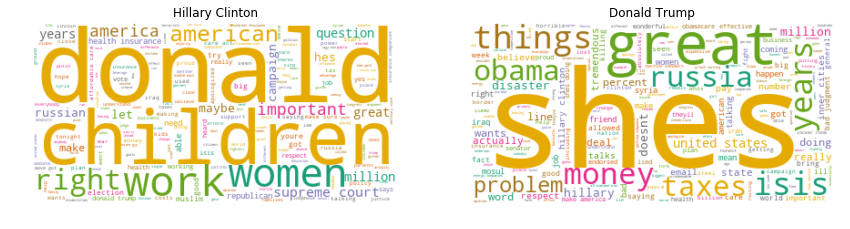

In [189]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 30]

full_names = ['Hillary Clinton', 'Donald Trump']

# Create subplots for each nominee
for index, nominee in enumerate(data.columns):
    wc.generate(data_clean.transcript[nominee])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

In [159]:

# Find the number of unique words that each nominee uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for nominee in data.columns:
    uniques = data[nominee].nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names, unique_list)), columns=['nominee', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,nominee,unique_words
1,Donald Trump,1044
0,Hillary Clinton,1095


In [160]:
# Calculate the words per minute of each nominee

# Find the total number of words that the nominee uses
total_list = []
for nominee in data.columns:
    totals = sum(data[nominee])
    total_list.append(totals)
    
run_times = [30,30]

#add new columns to our dataframe
data_words['total_words'] = total_list
data_words['run_times'] = run_times
data_words['words_per_minute'] = data_words['total_words'] / data_words['run_times']

# Sort the dataframe by words per minute to see who talks faster
data_wpm_sort = data_words.sort_values(by='words_per_minute')
data_wpm_sort


,nominee,unique_words,total_words,run_times,words_per_minute
0,Hillary Clinton,1095,2362,30,78.733333
1,Donald Trump,1044,2898,30,96.600000


In [195]:
# Read the corpus which preserves word ordering
import pandas as pd

data = pd.read_pickle('corpus.pkl')
#data

In [162]:
# Create lambda functions to find the polarity and subjectivity of each routine
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = data['transcript'].apply(pol)
data['subjectivity'] = data['transcript'].apply(sub)
data

,transcript,full_name,polarity,subjectivity
Clinton,"Well, thank you. Are you a teacher? Yes, I think that that’s a very good question, because I’ve heard from lots of teachers and parents about some...",Hillary Clinton,0.162752,0.480687
Trump,"Well, I actually agree with that. I agree with everything she said. I began this campaign because I was so tired of seeing such foolish things hap...",Donald Trump,0.100916,0.527695


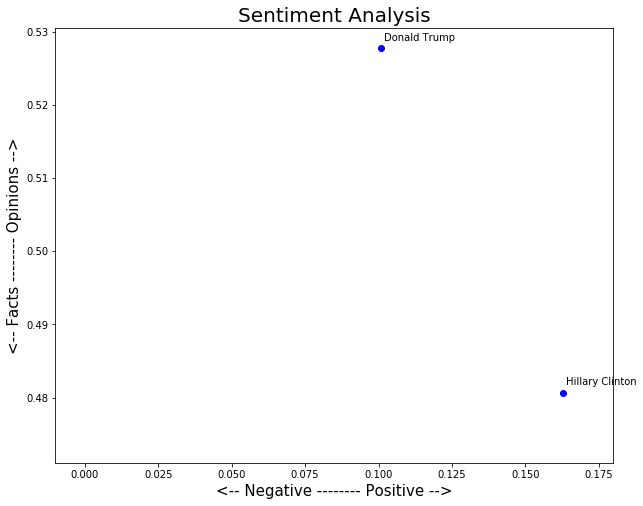

In [163]:
# Plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, nominee in enumerate(data.index):
    x = data.polarity.loc[nominee]
    y = data.subjectivity.loc[nominee]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, data['full_name'][index], fontsize=10)
    plt.xlim(-.01, .18) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()